**Proyecto 1**

Técnicas aprendizaje máquina

Pontificia Universidad Javeriana

Integrantes:


*   Juliana Rubio
*   Juan Andres Torres
*   Neyl Peñuela Bernate


In [ ]:
import os
import kagglehub
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

## Lectura de Datos

In [ ]:
# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [ ]:
dataset_path = '/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2'
print(os.listdir(dataset_path))


['chest_xray']


In [ ]:
for folder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(subfolder_path):
        for sub_folder in os.listdir(subfolder_path):
            sub_subfolder_path = os.path.join(subfolder_path, sub_folder)
            print(f"\nContenido de '{sub_folder}':", os.listdir(sub_subfolder_path))
            print(sub_subfolder_path)


Contenido de 'train': ['PNEUMONIA', 'NORMAL']
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train

Contenido de 'test': ['PNEUMONIA', 'NORMAL']
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test

Contenido de 'val': ['PNEUMONIA', 'NORMAL']
/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"

# Eliminar la carpeta __MACOSX
macosx_path = os.path.join(dataset_path, "__MACOSX")
if os.path.exists(macosx_path):
    shutil.rmtree(macosx_path)
    print("Carpeta '__MACOSX' eliminada correctamente.")

# Eliminar la carpeta chest_xray
chest_xray_path = os.path.join(dataset_path, "chest_xray")
if os.path.exists(chest_xray_path):
    shutil.rmtree(chest_xray_path)

In [ ]:
for folder in os.listdir(dataset_path):
    subfolder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(subfolder_path):
        print(f"\nContenido de '{folder}':", os.listdir(subfolder_path))


Contenido de 'train': ['PNEUMONIA', 'NORMAL']

Contenido de 'test': ['PNEUMONIA', 'NORMAL']

Contenido de 'val': ['PNEUMONIA', 'NORMAL']


## División: Entrenamiento, Validación y Prueba

In [ ]:
labels = ['NORMAL', 'PNEUMONIA']  # Clase 0: NORMAL, Clase 1: PNEUMONIA
img_size = 200  # Tamaño de las imágenes (200x200 pixeles). Buena proporción entre rendimiento y detalle.

def get_images(dataset_path):
    images = []
    img_labels = []
    for label in labels:
        path = os.path.join(dataset_path, label)
        class_num = 1 if label == 'PNEUMONIA' else 0  # Asigna 1 a PNEUMONIA, 0 a NORMAL
        for img in os.listdir(path):
            try:
              img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) # Leemos en escala de grises
              img_resize = cv2.resize(img_arr, (img_size, img_size)) # (200x200 pixeles)
              images.append(img_resize)
              img_labels.append(class_num)
            except Exception as e:
              print(e)
    return np.array(images), np.array(img_labels)

In [ ]:
train = get_images('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train')
test = get_images('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test')
val = get_images('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val')

## Análisis exploratorio

In [ ]:
from skimage.feature.texture import graycomatrix, graycoprops
import numpy as np
from skimage import io, color, img_as_ubyte



def calcular_caracteristicas_primer(imagen, distancia=1, angulos=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Calcula características de textura GLCM."""
    # Si la imagen tiene 3 canales (RGB), conviértela a escala de grises
    if len(imagen.shape) == 3 and imagen.shape[-1] == 3:
        imagen_gris = color.rgb2gray(imagen)
    else:
        imagen_gris = imagen  # Ya está en escala de grises

    imagen_gris = img_as_ubyte(imagen_gris)  # Convierte a uint8
    glcm = graycomatrix(imagen_gris, [distancia], angulos, symmetric=True, normed=True)

    caracteristicas = {
        'contraste': graycoprops(glcm, 'contrast')[0, 0],
        'disimilitud': graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneidad': graycoprops(glcm, 'homogeneity')[0, 0],
        'energia': graycoprops(glcm, 'energy')[0, 0],
        'correlacion': graycoprops(glcm, 'correlation')[0, 0]
    }

    return caracteristicas


#imagen = io.imread('ruta/a/tu/imagen.png')
#caracteristicas = calcular_caracteristicas_textura(imagen)
#print(caracteristicas)

In [ ]:
def plot_normal(imagen, label):
  filtro = np.array([[1, 0, 0],
                    [0,  1, 0],
                    [0, 0, 1]])

  # Aplicar el filtro de convolución
  imagen_filtrada = cv2.filter2D(imagen, -1, filtro)

  # Mostrar la imagen original y la imagen filtrada
  plt.figure(figsize=(10, 5))

  # Imagen original
  plt.subplot(1, 2, 1)
  plt.imshow(imagen, cmap='gray')
  plt.title('Imagen Original (Gradiente)')
  plt.axis('off')

  # Imagen filtrada
  plt.subplot(1, 2, 2)
  plt.imshow(imagen_filtrada, cmap='gray')
  plt.title(f'Imagen con Filtro de Convolución {label}')
  plt.axis('off')

  plt.show()

def plot_negativo(imagen,label):
  filtro = np.array([[-1, -1, -1],
                    [0,  0, 0],
                    [1, 1, 1]])


  # Aplicar el filtro de convolución
  imagen_filtrada = cv2.filter2D(imagen, -1, filtro)

  # Mostrar la imagen original y la imagen filtrada
  plt.figure(figsize=(10, 5))

  # Imagen original
  plt.subplot(1, 2, 1)
  plt.imshow(imagen, cmap='gray')
  plt.title(f'Imagen Original (Gradiente) {label}')
  plt.axis('off')

  # Imagen filtrada
  plt.subplot(1, 2, 2)
  plt.imshow(imagen_filtrada, cmap='gray')
  plt.title('Imagen con Filtro de Convolución Negativo')
  plt.axis('off')
  caracteristicas = calcular_caracteristicas_textura(imagen_filtrada)
  print(caracteristicas)
  plt.show()
  return imagen_filtrada


def ciclo(imagen, label):

  plot_normal(imagen,label)
  caracteristicas = calcular_caracteristicas_textura(imagen)
  print(caracteristicas)
  x=plot_negativo(imagen,label)
  # Redimensionar la imagen a un tamaño más pequeño para facilitar la visualización

  filtro = np.array([[-1, -1, -1],
                    [0,  0, 0],
                    [1, 1, 1]])

  # Aplicar el filtro de convolución
  imagen_filtrada = cv2.filter2D(imagen, -1, filtro)
  imagen = cv2.resize(imagen_filtrada, (100, 100))

  # Convertir la imagen a un array 4D (batch_size, altura, anchura, canales) para Keras
  imagen_4d = np.expand_dims(imagen, axis=(0, -1))

  # Definir la operación de Max Pooling 2x2 con TensorFlow/Keras
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

  # Aplicar Max Pooling
  imagen_pooling = pool(imagen_4d).numpy()

  # Eliminar dimensiones adicionales para visualizar correctamente
  imagen_pooling = np.squeeze(imagen_pooling)

  # Mostrar la imagen original y la imagen con Max Pooling
  plt.figure(figsize=(10, 5))

  # Imagen original
  plt.subplot(1, 2, 1)
  plt.imshow(imagen, cmap='gray')
  plt.title(f'Imagen Original {label}')
  plt.axis('off')

  # Imagen con Max Pooling
  plt.subplot(1, 2, 2)
  plt.imshow(imagen_pooling, cmap='gray')
  plt.title('Imagen con Max Pooling 2x2')
  plt.axis('off')
  plt.show()

  print("EPA")
  # Pass the image (imagen) instead of the label to calcular_caracteristicas_textura
  caracteristicas = calcular_caracteristicas_textura(imagen_pooling)
  print(caracteristicas)
  return

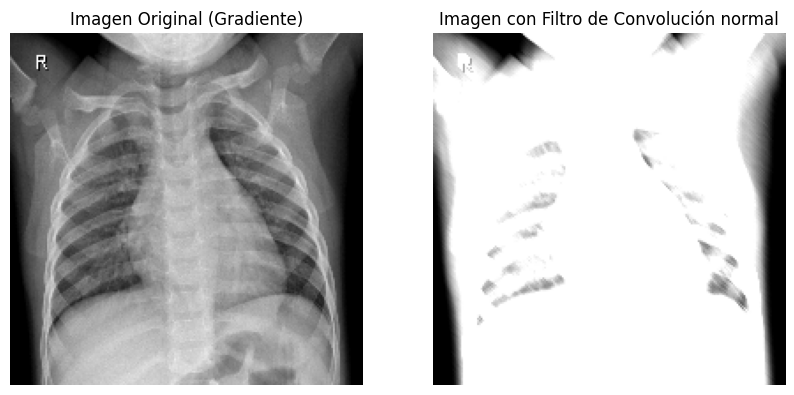

{'contraste': 176.61612714956846, 'disimilitud': 7.82106086336218, 'homogeneidad': 0.19256231580929123, 'energia': 0.05819718817362299, 'correlacion': 0.9728839589113583}
{'contraste': 352.5389437451254, 'disimilitud': 9.418770012121257, 'homogeneidad': 0.4278592941120872, 'energia': 0.3747796856882377, 'correlacion': 0.6540616652374984}


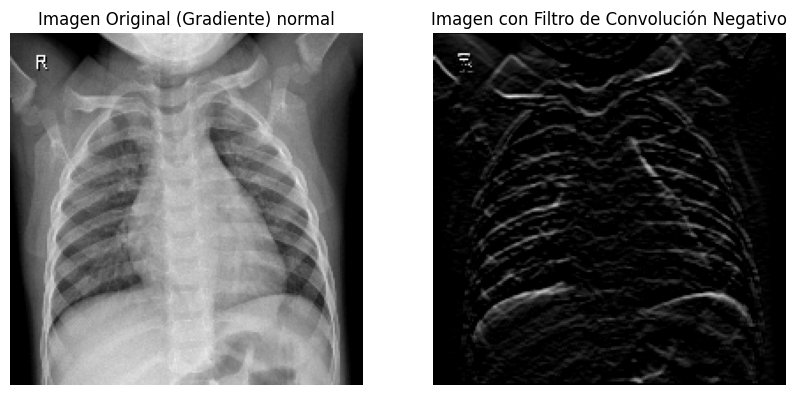

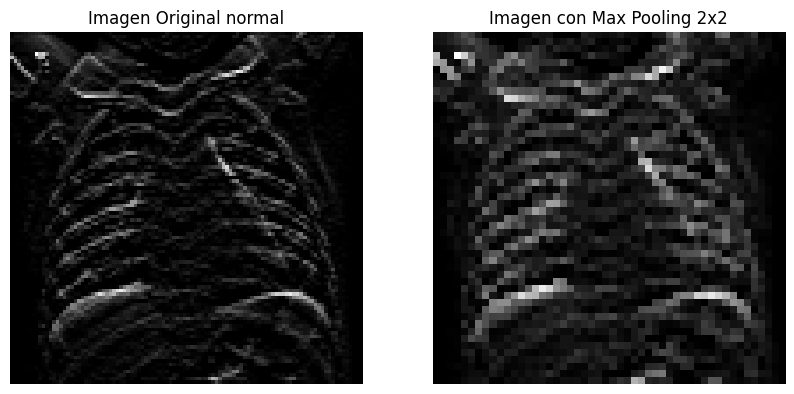

EPA
{'contraste': 807.9913785922413, 'disimilitud': 18.081799250312066, 'homogeneidad': 0.12895803970788466, 'energia': 0.05478731385804731, 'correlacion': 0.3984060014028571}


In [ ]:
# Mostramos una imagen de cada clase

X_train, y_train = train

normal_img = X_train[np.where(y_train == 0)[0][0]]
#label_normal_img = y_train[np.where(y_train == 0)[0][0]]
pneumonia_img = X_train[np.where(y_train == 1)[0][0]]
#ciclo_solo_metricas(normal_img, "normal")

#label_pneumonia_img = y_train[np.where(y_train == 1)[0][0]]

ciclo(normal_img, "normal")


# plt.figure(figsize=(8, 4))

# plt.subplot(1, 2, 1)
# plt.imshow(normal_img, cmap='gray')
# plt.title('Normal')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(pneumonia_img, cmap='gray')
# plt.title('Pneumonia')
# plt.axis('off')

# plt.show()


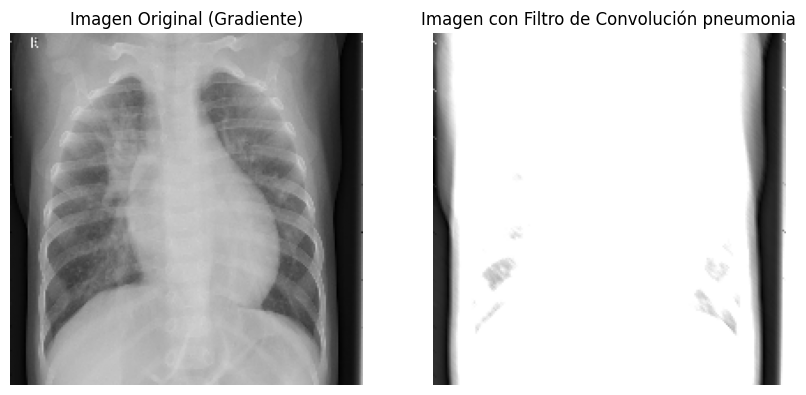

{'contraste': 91.40457182268129, 'disimilitud': 5.132452621145961, 'homogeneidad': 0.26932649953961607, 'energia': 0.0261841960638374, 'correlacion': 0.985175749606247}
{'contraste': 119.02151820661447, 'disimilitud': 4.917346531653375, 'homogeneidad': 0.4850660188696415, 'energia': 0.374537881409948, 'correlacion': 0.7039261116087552}


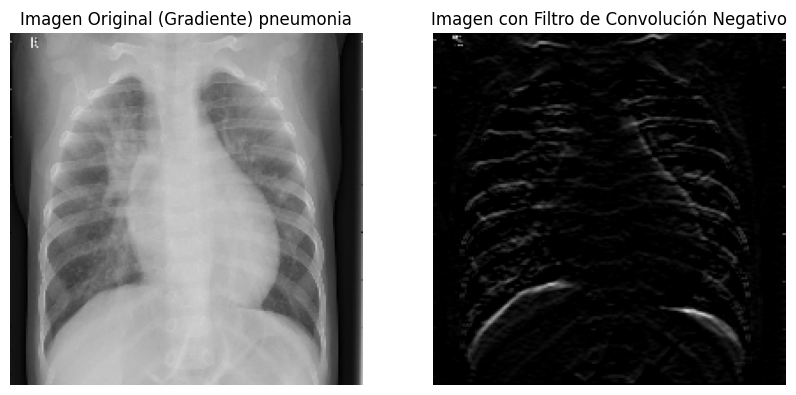

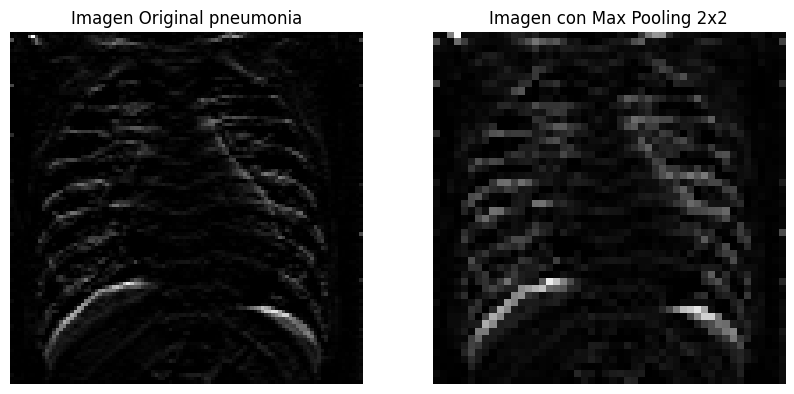

EPA
{'contraste': 348.2075572678015, 'disimilitud': 10.518215326947013, 'homogeneidad': 0.19228682105742823, 'energia': 0.06355669984349718, 'correlacion': 0.42306538083424067}


In [ ]:
ciclo(pneumonia_img, "pneumonia")

In [ ]:
def carac_normal(imagen, label):
  filtro = np.array([[1, 0, 0],
                    [0,  1, 0],
                    [0, 0, 1]])

  # Aplicar el filtro de convolución
  imagen_filtrada = cv2.filter2D(imagen, -1, filtro)

  # Mostrar la imagen original y la imagen filtrada
  print("Caracteristicas de imagen Convolucionada")
  caracteristicas = calcular_caracteristicas_textura(imagen_filtrada)

  print(caracteristicas)

def carac_negativo(imagen,label):
  filtro = np.array([[-1, -1, -1],
                    [0,  0, 0],
                    [1, 1, 1]])


  # Aplicar el filtro de convolución
  imagen_filtrada = cv2.filter2D(imagen, -1, filtro)

  # Mostrar la imagen original y la imagen filtrada

  caracteristicas = calcular_caracteristicas_textura(imagen_filtrada)
  print("Caracteristicas del filtro negativo")
  print(caracteristicas)

  return imagen_filtrada


def ciclo_solo_metricas(imagen, label):

  carac_normal(imagen,label)
  print("Caracteristicas de la imagen original ")
  caracteristicas = calcular_caracteristicas_textura(imagen)
  print(caracteristicas)
  x=carac_negativo(imagen,label)
  # Redimensionar la imagen a un tamaño más pequeño para facilitar la visualización

  filtro = np.array([[-1, -1, -1],
                    [0,  0, 0],
                    [1, 1, 1]])

  # Aplicar el filtro de convolución
  imagen_filtrada = cv2.filter2D(imagen, -1, filtro)
  imagen = cv2.resize(imagen_filtrada, (100, 100))

  # Convertir la imagen a un array 4D (batch_size, altura, anchura, canales) para Keras
  imagen_4d = np.expand_dims(imagen, axis=(0, -1))

  # Definir la operación de Max Pooling 2x2 con TensorFlow/Keras
  pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))

  # Aplicar Max Pooling
  imagen_pooling = pool(imagen_4d).numpy()

  # Eliminar dimensiones adicionales para visualizar correctamente
  imagen_pooling = np.squeeze(imagen_pooling)

  print("Caracteristicas de imagen_pooling")

  caracteristicas = calcular_caracteristicas_textura(imagen_pooling)
  print(caracteristicas)
  return

Atelectasias y opacidades: Presta especial atención a la presencia de atelectasias (colapso pulmonar) y opacidades (áreas más densas), que son comunes en pacientes con COVID-19.
Patrones de vidrio deslustrado: Busca patrones de vidrio deslustrado, que son áreas de opacidad difusa que pueden indicar inflamación pulmonar.
Distribución de anomalías: Observa la distribución de las anomalías en los pulmones. El COVID-19 tiende a afectar las áreas periféricas de los pulmones

In [ ]:
ciclo_solo_metricas(normal_img, "normal")


Caracteristicas de imagen Convolucionada
{'contraste': 111.52031271306468, 'disimilitud': 3.3351379068711022, 'homogeneidad': 0.8185818883931145, 'energia': 0.7573509695163488, 'correlacion': 0.9889191239666661}
Caracteristicas de la imagen original 
{'contraste': 176.61612714956846, 'disimilitud': 7.82106086336218, 'homogeneidad': 0.19256231580929123, 'energia': 0.05819718817362299, 'correlacion': 0.9728839589113583}
Caracteristicas del filtro negativo
{'contraste': 352.5389437451254, 'disimilitud': 9.418770012121257, 'homogeneidad': 0.4278592941120872, 'energia': 0.3747796856882377, 'correlacion': 0.6540616652374984}
Caracteristicas de imagen_pooling
{'contraste': 807.9913785922413, 'disimilitud': 18.081799250312066, 'homogeneidad': 0.12895803970788466, 'energia': 0.05478731385804731, 'correlacion': 0.3984060014028571}


In [ ]:
ciclo_solo_metricas(pneumonia_img, "pneumonia")

Caracteristicas de imagen Convolucionada
{'contraste': 96.11781230272088, 'disimilitud': 2.8642243882730822, 'homogeneidad': 0.8310892513861884, 'energia': 0.7997647880720363, 'correlacion': 0.987202425602496}
Caracteristicas de la imagen original 
{'contraste': 91.40457182268129, 'disimilitud': 5.132452621145961, 'homogeneidad': 0.26932649953961607, 'energia': 0.0261841960638374, 'correlacion': 0.985175749606247}
Caracteristicas del filtro negativo
{'contraste': 119.02151820661447, 'disimilitud': 4.917346531653375, 'homogeneidad': 0.4850660188696415, 'energia': 0.374537881409948, 'correlacion': 0.7039261116087552}
Caracteristicas de imagen_pooling
{'contraste': 348.2075572678015, 'disimilitud': 10.518215326947013, 'homogeneidad': 0.19228682105742823, 'energia': 0.06355669984349718, 'correlacion': 0.42306538083424067}


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import color, img_as_ubyte

def calcular_caracteristicas_textura(imagen, distancia=1, angulos=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    if imagen.dtype == np.float32 or imagen.dtype == np.float64:
        imagen = np.clip(imagen, 0, 1)  # Asegura valores entre 0 y 1

    # Si la imagen tiene un solo canal (200, 200, 1), conviértela a 3 canales (200, 200, 3)
    if len(imagen.shape) == 3 and imagen.shape[-1] == 1:
        imagen = np.repeat(imagen, 3, axis=-1)

    # Si la imagen tiene 3 canales, la convertimos a escala de grises
    if len(imagen.shape) == 3 and imagen.shape[-1] == 3:
        imagen_gris = img_as_ubyte(color.rgb2gray(imagen))
    else:
        imagen_gris = img_as_ubyte(imagen.squeeze())  # Asegura que sea 2D sin canal extra

    glcm = graycomatrix(imagen_gris, [distancia], angulos, symmetric=True, normed=True)
    caracteristicas = {
        'contraste': graycoprops(glcm, 'contrast').mean(),
        'disimilitud': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneidad': graycoprops(glcm, 'homogeneity').mean(),
        'energia': graycoprops(glcm, 'energy').mean(),
        'correlacion': graycoprops(glcm, 'correlation').mean()
    }
    return caracteristicas

def aplicar_max_pooling(imagen):
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    imagen_4d = np.expand_dims(imagen, axis=(0,-1))
    imagen_pooling = pool(imagen_4d).numpy()
    imagen_pooling = np.squeeze(imagen_pooling)
    return imagen_pooling




def aplicar_filtro_y_calcular(imagen, filtro):
    imagen_filtrada = cv2.filter2D(imagen, -1, filtro)
    return calcular_caracteristicas_textura(imagen_filtrada)

def calcular_promedio_metricas(imagenes):
    filtros = {
       # 'Original': None,  # No se aplica filtro
        'Normal': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
        'Negativo': np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),
        'MaxPooling': 'pooling'
    }

    metricas_totales = {key: {m: [] for m in ['contraste', 'disimilitud', 'homogeneidad', 'energia', 'correlacion']} for key in filtros}


    for imagen in imagenes:
        for nombre, filtro in filtros.items():
            if nombre == 'MaxPooling':
                imagen_procesada = aplicar_max_pooling(imagen)
                metricas = calcular_caracteristicas_textura(imagen_procesada)
            elif nombre == 'Original':
                metricas = calcular_caracteristicas_textura(imagen)
            else:
                metricas = aplicar_filtro_y_calcular(imagen, filtro)
            for k, v in metricas.items():
                metricas_totales[nombre][k].append(v)
    # Promediar las métricas por filtro
    return {nombre: {k: np.mean(v) for k, v in valores.items()} for nombre, valores in metricas_totales.items()}




def graficar_comparacion(metricas_normales, metricas_pneumonia):
    categorias = list(metricas_normales['Normal'].keys())  # Lista de métricas
    x = np.arange(len(categorias))  # Posiciones en el eje X
    width = 0.4  # Ancho de las barras

    # Obtener los valores promedio de cada métrica
    valores_normales = [metricas_normales['Normal'][c] for c in categorias]
    valores_pneumonia = [metricas_pneumonia['Normal'][c] for c in categorias]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Graficar las barras
    ax.bar(x - width/2, valores_normales, width, label='Normal', color='blue', alpha=0.7)
    ax.bar(x + width/2, valores_pneumonia, width, label='Neumonía', color='red', alpha=0.7)

    # Configuración de la gráfica
    ax.set_xticks(x)
    ax.set_xticklabels(categorias, rotation=45)
    ax.set_title('Comparación de métricas entre imágenes normales y con neumonía')
    ax.legend()

    # Agregar tabla con los valores promedio
    tabla_datos = np.array([valores_normales, valores_pneumonia]).T
    tabla_filas = ['Normal', 'Neumonía']
    tabla = ax.table(cellText=tabla_datos, rowLabels=categorias, colLabels=tabla_filas,
                     cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])

    plt.subplots_adjust(bottom=0.3)  # Ajustar espacio para la tabla
    plt.show()


# Cargar imágenes de entrenamiento
imagenes_normales = [X_train[i] for i in np.where(y_train == 0)[0][:50]]  # Tomamos 10 imágenes normales
imagenes_pneumonia = [X_train[i] for i in np.where(y_train == 1)[0][:50]]  # Tomamos 10 imágenes con neumonía

metricas_normales = calcular_promedio_metricas(imagenes_normales)
metricas_pneumonia = calcular_promedio_metricas(imagenes_pneumonia)

graficar_comparacion(metricas_normales, metricas_pneumonia)


ValueError: Input 0 of layer "max_pooling2d_1" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (1, 200, 200)

In [ ]:

def graficar_comparacion(metricas_normales, metricas_pneumonia):
    categorias = list(metricas_normales['Normal'].keys())  # Lista de métricas
    x = np.arange(len(categorias))  # Posiciones en el eje X
    width = 0.4  # Ancho de las barras

    # Obtener los valores promedio de cada métrica
    valores_normales = [metricas_normales['Normal'][c] for c in categorias]
    valores_pneumonia = [metricas_pneumonia['Normal'][c] for c in categorias]

    fig, ax = plt.subplots(figsize=(10, 6))

    # Graficar las barras
    ax.bar(x - width/2, valores_normales, width, label='Normal', color='blue', alpha=0.7)
    ax.bar(x + width/2, valores_pneumonia, width, label='Neumonía', color='red', alpha=0.7)

    # Configuración de la gráfica
    ax.set_xticks(x)
    ax.set_xticklabels(categorias, rotation=45)
    ax.set_title('Comparación de métricas entre imágenes normales y con neumonía (Promedio de muestra n=50)')
    ax.legend()

    # Agregar tabla con los valores promedio
    tabla_datos = np.array([valores_normales, valores_pneumonia]).T
    tabla_filas = ['Normal', 'Neumonía']
    tabla = ax.table(cellText=tabla_datos, rowLabels=categorias, colLabels=tabla_filas,
                     cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3])

    plt.subplots_adjust(bottom=0.3)  # Ajustar espacio para la tabla
    plt.show()

graficar_comparacion(metricas_normales, metricas_pneumonia)

## Balance de datos de entrenamiento

In [ ]:
# Desempaquetamos las imágenes y etiquetas
X_train, y_train = train

# Contamos las etiquetas
Pneumonia = np.sum(y_train == 1)
Normal = np.sum(y_train == 0)

# Graficamos la distribución de clases
plt.bar(['Pneumonia', 'Normal'], [Pneumonia, Normal], color=['red', 'green'])
plt.xlabel('Clases')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.show()

## Normalización y Aumentación de Datos

In [ ]:
# Convertimos los valores de los píxeles de [0, 255] a [0, 1].

X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

In [ ]:
# Transformamos los datos para que sean compatibles con el modelo

X_train = X_train.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)

In [ ]:
# Generador de aumento de datos con parámetros optimizados
datagen = ImageDataGenerator(
    rotation_range=20,              # Rotación aleatoria de hasta 20 grados
    zoom_range=0.15,                # Zoom aleatorio de hasta un 15%
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio (10% del ancho)
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio (10% de la altura)
    horizontal_flip=True,           # Volteo horizontal aleatorio
    vertical_flip=False,            # No se realiza volteo vertical
)

datagen.fit(X_train)

## Red Neuronal

In [ ]:
model = Sequential()

# Bloque convolucional 1
model.add(Conv2D(32, (3,3), padding='same', activation = 'relu', input_shape=(200, 200, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Bloque convolucional 2
model.add(Conv2D(64, (3,3), padding='same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))


# Bloque convolucional 3
model.add(Conv2D(128, (3,3), padding='same', activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Bloque convolucional 4
model.add(Conv2D(256, (3,3), padding='same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

# Aplanado y capas densas
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilación del modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


## Entrenamiento

In [ ]:
# Callbacks para mejorar el entrenamiento

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=6,
                               restore_best_weights=True,
                               verbose=1)


history = model.fit(datagen.flow(X_train,y_train, batch_size = 32),
                    epochs = 12,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks = [learning_rate_reduction, early_stopping])


In [ ]:
# Graficas de las métricas del entrenamiento

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Gráfica de la precisión
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión en el entrenamiento y validación')
plt.legend()

# Gráfica de la pérdida
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida en el entrenamiento y validación')
plt.legend()

plt.tight_layout()
plt.show()


## Predicción en los Datos de Prueba

In [ ]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # Umbral del 50% para clasificar

In [ ]:
# Creamos la matriz de confusión
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])

# Mostramos la matriz de confusión
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Matriz de Confusión en Datos de Prueba')
plt.show()

In [ ]:
# Reporte detallado con precisión, recall, f1-score y support
print(classification_report(y_test, predictions, target_names=['NORMAL', 'PNEUMONIA']))

# Métrica de precisión general
print(f"Precisión global del modelo: {accuracy_score(y_test, predictions):.2f}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generar_mapa_calor(modelo, imagen, clase_objetivo, ultimo_nombre_capa):
    """Genera un mapa de calor Grad-CAM para una imagen y una clase objetivo."""
    imagen_expandida = np.expand_dims(imagen, axis=0)
    predicciones = modelo.predict(imagen_expandida)
    indice_clase = np.argmax(predicciones[0])

    with tf.GradientTape() as tape:
        ultimo_mapa_capa, predicciones = modelo.get_layer(ultimo_nombre_capa)(imagen_expandida)
        if indice_clase is None:
            indice_clase = tf.argmax(predicciones[0])
        clase_salida = predicciones[:, indice_clase]

    gradientes = tape.gradient(clase_salida, ultimo_mapa_capa)
    gradientes_ponderados = tf.reduce_mean(gradientes, axis=(0, 1, 2))

    mapa_calor = np.mean(ultimo_mapa_capa.numpy()[0], axis=-1)
    for i, grad in enumerate(gradientes_ponderados):
        mapa_calor += grad.numpy() * ultimo_mapa_capa.numpy()[0, :, :, i]

    mapa_calor = np.maximum(mapa_calor, 0) / np.max(mapa_calor)
    mapa_calor = cv2.resize(mapa_calor, (imagen.shape[1], imagen.shape[0]))
    return mapa_calor

def visualizar_mapa_calor(imagen_original, mapa_calor, nombre_archivo_salida):
    """Superpone el mapa de calor en la imagen original y la guarda."""
    mapa_calor_superpuesto = cv2.addWeighted(imagen_original, 0.6, mapa_calor, 0.4, 0)
    plt.imshow(cv2.cvtColor(mapa_calor_superpuesto, cv2.COLOR_BGR2RGB))
    plt.savefig(nombre_archivo_salida)

# Ejemplo de uso
# Cargar modelo y preprocesar la imagen
modelo = keras.models.load_model('ruta/a/tu/modelo.h5')
imagen_original = cv2.imread('ruta/a/tu/imagen.png')
imagen_redimensionada = cv2.resize(imagen_original, (224, 224)) # Ejemplo de tamaño
imagen_normalizada = keras.applications.vgg16.preprocess_input(imagen_redimensionada)

# Generar y visualizar el mapa de calor
mapa_calor = generar_mapa_calor(modelo, imagen_normalizada, None, 'ultimo_nombre_capa') # Reemplaza 'ultimo_nombre_capa'
visualizar_mapa_calor(imagen_original, mapa_calor, 'mapa_calor.png')